In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy 
import pdb
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt
import sys

In [3]:
sys.path.append('/home/akumar/nse/neural_control/')

In [4]:
from utils import gram_schmidt

### 

### Tuning Polar Decomposition

In [6]:
def FCCA_score(A):
    P = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))
    # Resolve the contribution of the different terms
    X1 = P @ A.T @ np.linalg.inv(P) @ A
    X2 = A @ P @ A.T @ np.linalg.inv(P)
    X3 = A @ P @ A.T @ A.T @ np.linalg.inv(P) @ A

    # return np.trace(np.eye(A.shape[0]) - P @ A.T @ np.linalg.inv(P) @ A - A @ P @ A.T @ np.linalg.inv(P) + A @ P @ A.T @ A.T @ np.linalg.inv(P) @ A)
    return X1, X2, X3

def LQG_score(A):
    P = scipy.linalg.solve_discrete_are(A, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    Q = scipy.linalg.solve_discrete_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))

    return np.trace(P @ Q)

In [9]:
# Generate A matrices 
dim = 100
nU = 50
nP = 50
seed = 1
# 50 random U matrices. Then modulate the spread of the diagonals of P for each U

U = []
for i in range(nU):
    U.append(special_ortho_group.rvs(dim))

Puniform = []
for j in range(nP):
    Puniform.append(np.diag(np.linspace(0.775 - j/nP * 0.6, 0.8 + j/nP * 0.6, dim)))
# for i in range(50):

# Check to make sure all eigenvalues have real part < 1
A = [[] for _ in range(nU)]
lambda_max = np.zeros((nU, nP, 2))
for i in range(len(U)):
    for j in range(len(Puniform)):
        A_ = U[i] @ Puniform[j]
        lambda_max[i, j, 0] = np.max(np.abs(np.linalg.eigvals(A_)))     
        A[i].append(A_)

assert(np.all(lambda_max < 1))


In [10]:
from tqdm import tqdm

In [11]:
fcca_scores = np.zeros((nU, nP, 7))
lqg_scores = np.zeros((nU, nP))
normdU = np.zeros((nU, nP))
for i in tqdm(range(nU)):
    for j in range(nP):
        x1, x2, x3 = FCCA_score(A[i][j])
        fcca_scores[i, j, 0] = -1 * np.trace(x1)
        fcca_scores[i, j, 1] = -1 * np.trace(x2)
        fcca_scores[i, j, 2] = np.trace(x3)
        fcca_scores[i, j, 3] = np.trace(np.eye(A[i][j].shape[0])) - np.trace(x1) - np.trace(x2) + np.trace(x3)
        lqg_scores[i, j] = LQG_score(A[i][j])

        U_, P_ = scipy.linalg.polar(A[i][j])
        normdU[i, j] = np.linalg.norm(A[i][j] - U_)/np.linalg.norm(A[i][j])

100%|██████████| 50/50 [05:18<00:00,  6.38s/it]


In [12]:
with open('polar_tmp.pkl', 'wb') as f:
    f.write(fcca_scores)
    f.write(lqg_scores)
    f.write(normdU)

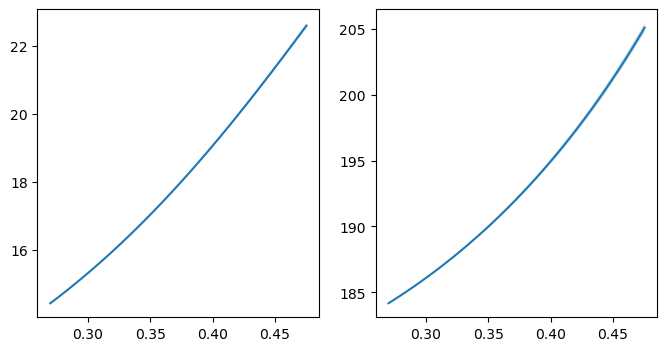

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].fill_between(np.mean(normdU, axis=0), np.mean(fcca_scores[..., 3], axis=0) - np.std(fcca_scores[..., 3], axis=0), 
                   np.mean(fcca_scores[..., 3], axis=0) + np.std(fcca_scores[..., 3], axis=0), alpha=0.25)
ax[0].plot(np.mean(normdU, axis=0), np.mean(fcca_scores[..., 3], axis=0))
ax[1].fill_between(np.mean(normdU, axis=0), np.mean(lqg_scores, axis=0) - np.std(lqg_scores, axis=0), 
                   np.mean(lqg_scores, axis=0) + np.std(lqg_scores, axis=0), alpha=0.25)
ax[1].plot(np.mean(normdU, axis=0), np.mean(lqg_scores, axis=0))


In [37]:
np.allclose(fcca_scores[:, 0], fcca_scores[:, 1])

True

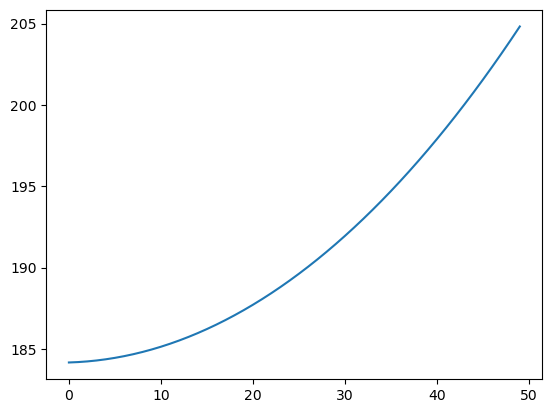

In [28]:
# How dependent is this on the actual objective?
plt.plot(lqg_scores)

In [34]:
# Is it possible to capture analytically the above behavior via an upper bound?

In [ ]:
# Could alternatively think about the LQG singular values. Here, formulas for the trace of the matrix product may be more directly applicable

In [ ]:
# Simplify to a 2x2 system to get more traction

In [94]:
# Check Wolfram Expression
def get_W(th, delta, eps):

    U = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    P = np.diag([1 - eps - delta, 1- eps + delta])
    A = U @ P

    assert(max(np.abs(np.linalg.eigvals(A.T))) < 1)

    W = scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0]))
    return W, A

In [102]:
# Plot of the different 2D dynamics

### 3D -> 2D projections

In [5]:
# In 3D -> 2D, we can use the orientation of the normal vector to define a projection. 
def get_V(theta, phi):
    n = np.array([np.sin(phi) * np.sin(theta), np.cos(phi) * np.sin(theta), np.cos(theta)])
    V = gram_schmidt(n)[:, 1:]
    try:
        assert(np.isclose(scipy.linalg.subspace_angles(V, n[:, np.newaxis]), np.pi/2))
    except:
        pdb.set_trace()
    return n, V

In [6]:
# Plot the normal vector and the plane spanned by the orthogonal directions
from mpl_toolkits.mplot3d import Axes3D

/home/akumar/nse/neural_control/utils.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:,j] = q/rjj


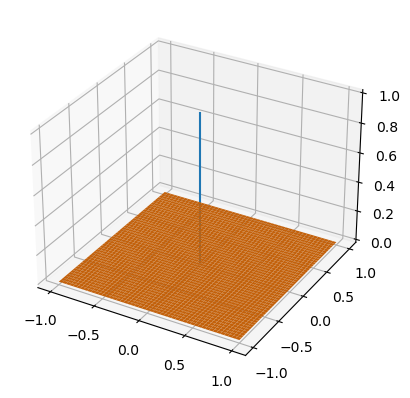

In [7]:
fig = plt.figure()

n, V = get_V(0, 0)

ax = fig.add_subplot(projection='3d')
ax.plot3D([0, n[0]], [0, n[1]], [0, n[2]])

# Plot plane

# create x,y
xx, yy = np.meshgrid(np.linspace(-1, 1), np.linspace(-1, 1))

# calculate corresponding z
z = (-n[0] * xx - n[1] * yy) * 1. /n[2]

# plot the surface
#plt3d = plt.figure().gca(projection='3d')
ax.plot_surface(xx, yy, z)

In [138]:
n

array([0.000000e+00, 1.000000e+00, 6.123234e-17])

In [139]:
V

array([[-0.20136342,  0.81656689],
       [ 0.        ,  0.        ],
       [-0.67974924, -0.43019624]])

In [143]:
%matplotlib inline

In [148]:
fig = plt.figure()

n, V = get_V(np.pi/2, 0)

ax = fig.add_subplot(projection='3d')
ax.plot3D([0, n[0]], [0, n[1]], [0, n[2]])

# Plot plane

# create x,y
xx, yy = np.meshgrid(np.linspace(-1, 1), np.linspace(-1, 1))

# calculate corresponding z
z = (-n[0] * xx - n[1] * yy) * 1. /n[2]

ax.set_zlim([-1.1, 1.1])

# plot the surface
#plt3d = plt.figure().gca(projection='3d')
ax.plot_surface(xx, yy, z)
fig.show()

/home/akumar/nse/neural_control/utils.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:,j] = q/rjj


AssertionError: 

<Figure size 640x480 with 0 Axes>

In [8]:
from sklearn.decomposition import PCA
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# How to parameterize these 

In [10]:
# Choose the rotation to be in the XY plane.
S = lambda x, y, z, th: np.array([[0, -z*th, y*th], [z*th, 0, -x*th], [-y*th, x*th, 0]]) 
O = lambda x, y, z, th: scipy.linalg.expm(S(x, y, z, th))
P = lambda delta, eps: np.diag([1 - delta - eps, 1 - delta - eps, 1 + delta - eps])

In [11]:
th = np.pi/16
eps = 1e-3
x = 1
y = 1
z = 1
delta = np.array([0, 0.05, 0.1, 0.15])

A = []
for i in range(delta.size):
    A.append(O(x, y, z, th) @ P(delta[i], eps))
    print(max(np.abs(np.linalg.eigvals(A[i]))))

0.9990000000000001
0.9818583620023207
0.9667394673738473
0.9610497418801789


In [12]:
O(x, y, z, th)

array([[ 0.96181701, -0.17349493,  0.21167792],
       [ 0.21167792,  0.96181701, -0.17349493],
       [-0.17349493,  0.21167792,  0.96181701]])

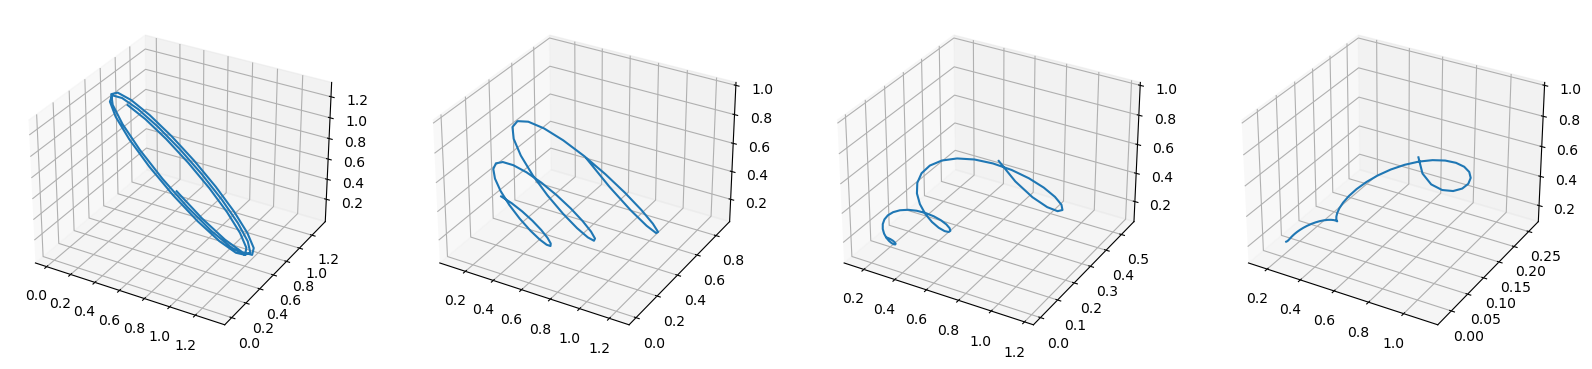

In [13]:
# Can we visualize what happens to trajectories as we sweep through these parameters?
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(141, projection='3d')
ax2 = fig.add_subplot(142, projection='3d')
ax3 = fig.add_subplot(143, projection='3d')
ax4 = fig.add_subplot(144, projection='3d')

a = [ax1, ax2, ax3, ax4]
for i in range(len(A)):
    x = np.array([np.linalg.matrix_power(A[i], k) @ np.array([1, 0, 1]) for k in range(50)])
    a[i].plot(x[:, 0], x[:, 1], x[:, 2])

# a[0].plot((0, 1/np.sqrt(2)), (0, 1/np.sqrt(2)), (0, 0))
# x1 = np.array([np.linalg.matrix_power(A, k) @ np.array([1, -1]) for k in range(50)])
# x2 = np.array([np.linalg.matrix_power(A2, k) @ np.array([1, -1]) for k in range(50)])
# x3 = np.array([np.linalg.matrix_power(A3, k) @ np.array([1, -1]) for k in range(50)])

# ax[0].plot(x[:, 0], x[:, 1])
# ax[1].plot(x2[:, 0], x2[:, 1])
# ax[2].plot(x3[:, 0], x3[:, 1])

# fig.savefig('/home/akumar/nse/neural_control/figs/synth/polar_2D_example.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
def LQG_score(A, V):

    P = scipy.linalg.solve_discrete_are(A, V, np.eye(A.shape[0]), np.eye(V.shape[1]))
    Q = scipy.linalg.solve_discrete_are(A.T, V, np.eye(A.shape[0]), np.eye(V.shape[1]))
    return np.trace(P @ Q)

In [18]:
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [20]:
from tqdm import tqdm

In [49]:
from pyuoi.linear_model.var import VAR

In [53]:
phi = np.linspace(0, np.pi/2)
theta = np.linspace(0, np.pi)

fcca_1step = np.zeros((len(A), phi.size, theta.size))
fcca_4step = np.zeros((len(A), phi.size, theta.size))
lqg_scores = np.zeros((len(A), phi.size, theta.size))

dU = np.zeros((len(A), phi.size, theta.size))

for h in range(len(A)):
    ssr = SSR(A[h], np.eye(A[h].shape[0]), np.eye(A[h].shape[0]))
    X = ssr.trajectory(int(1e6))
    lqgmodel4 = LQGCA(T=4)
    lqgmodel1 = LQGCA(T=1)

    lqgmodel4.estimate_data_statistics(X)
    lqgmodel1.estimate_data_statistics(X)

    for i, p in tqdm(enumerate(phi)):
        for j, th in enumerate(theta):
            n, V = get_V(p, th)
            fcca_1step[h, i, j] = lqgmodel1.score(V)
            fcca_4step[h, i, j] = lqgmodel4.score(V)
            lqg_scores[h, i, j] = LQG_score(A[h], V)

            x = X @ V

            varmodel = VAR(estimator='ols')
            varmodel.fit(x)
            F = np.squeeze(varmodel.coef_)
            U_, P_ = scipy.linalg.polar(F)
            dU = np.linalg.norm(F - U_)


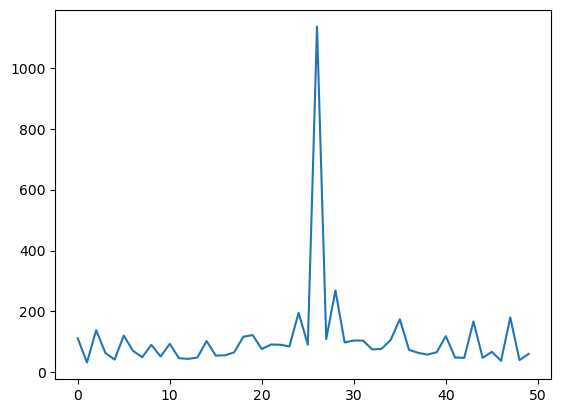

In [46]:
plt.plot(lqg_scores[0, :, 4])